In [1]:
from keras.utils import HDF5Matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.utils import to_categorical
from keras import backend as K
import keras.callbacks as cb
from keras.models import load_model
from keras.layers import Input, Dense, BatchNormalization, Dropout, Conv2D, MaxPool2D, Flatten, LeakyReLU, Concatenate, GlobalAveragePooling2D, UpSampling2D
from IPython.display import Image
from PIL import Image as pil_image

import keras
import tensorflow
import tensorflow.compat.v1 as tf
import numpy as np
import pandas as pd
import imageio
import cv2
import pprint
import os
import PIL

import src.model as my_model
import src.pcam_loader as data
import src.adaptive_model as am

Using TensorFlow backend.


# Show if tensorflow can run with GPU
# Run tensorflow keras on multiple core

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# config = tf.ConfigProto(device_count={"CPU": 8})
# tensorflow.compat.v1.keras.backend.set_session(tf.Session(config=config))
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7642442422647336113
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4854028697
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13408299200942586540
physical_device_desc: "device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:26:00.0, compute capability: 7.5"
]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:26:00.0, compute capability: 7.5



In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

# Load DAGM data

In [3]:
path = './data/class6/'

In [4]:
x_train_images = os.listdir(path + 'Train/')
x_test_images = os.listdir(path + 'Test/')

x_train = [np.asarray(pil_image.open(path + 'Train/' + image)) for image in x_train_images]
x_train = [np.reshape(image, image.shape + (1,)) for image in x_train]

x_test = [np.asarray(pil_image.open(path + 'Test/' + image)) for image in x_test_images]
x_test = [np.reshape(image, image.shape + (1,)) for image in x_test]

x_train = np.array(x_train)
x_valid = np.array(x_test[250:])
x_test = np.array(x_test[:250])

In [5]:
meta_test = pd.read_csv(path + 'Test.csv', sep=' ')
y_test = np.array(meta_test.class_type)
y_test = y_test.reshape(575,1)

meta_train = pd.read_csv(path + 'Train.csv', sep=' ')
y_train = np.array(meta_train.class_type)
y_train = y_train.reshape(575,1)

y_valid = y_test[250:]
y_test = y_test[:250]

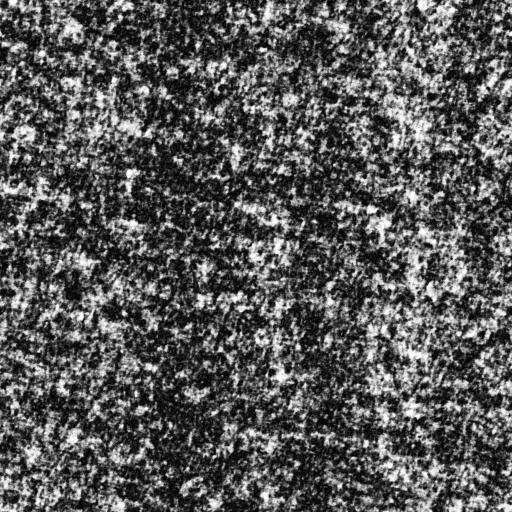

In [6]:
Image(filename=path + 'Test/' + x_test_images[2]) 

In [7]:
print(meta_train.head(5), '\n')
print(meta_train.info())

print('\n' + 'Shape of train', x_train.shape,  len(y_train), y_train.shape)
print('Shape of valid', x_valid.shape,  len(y_valid), y_valid.shape)
print('Shape of test', x_test.shape, len(y_test), y_test.shape)

     class_type picture_name  _  positive_label  __
576           0     0576.PNG  0               0 NaN
577           0     0577.PNG  0               0 NaN
578           0     0578.PNG  0               0 NaN
579           1     0579.PNG  0  0579_label.PNG NaN
580           0     0580.PNG  0               0 NaN 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 575 entries, 576 to 1150
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   class_type      575 non-null    int64  
 1   picture_name    575 non-null    object 
 2   _               575 non-null    int64  
 3   positive_label  575 non-null    object 
 4   __              0 non-null      float64
dtypes: float64(1), int64(2), object(2)
memory usage: 27.0+ KB
None

Shape of train (575, 512, 512, 1) 575 (575, 1)
Shape of valid (325, 512, 512, 1) 325 (325, 1)
Shape of test (250, 512, 512, 1) 250 (250, 1)


# Load pcam data

In [199]:
# Load data from /User/Username/.keras/datasets/pcam
dataset = data.load_data()
x_train, y_train, meta_train =  dataset[0]
x_valid, y_valid, meta_valid =  dataset[1]
x_test, y_test, meta_test =  dataset[2]

In [161]:
y_train = np.array(y_train[:])
y_train = y_train.reshape(-1, 1)
y_valid = np.array(y_valid[:])
y_valid = y_valid.reshape(-1, 1)
y_test = np.array(y_test[:])
y_test = y_test.reshape(-1, 1)

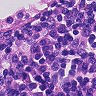

In [162]:
# Save data into png format and visualize image
# imageio.imwrite('image.png', )
Image(filename='./data/obrazky/image.png') 

In [163]:
print(meta_train.head(5), '\n')
print(meta_train.info())

# Shape of train, valid and test input are the same, don't need to preprocess
print('\n' + 'Shape of train', x_train.shape,  len(y_train), y_train.shape)
print('Shape of valid', x_valid.shape,  len(y_valid), y_valid.shape)
print('Shape of test', x_test.shape, len(y_test), y_test.shape)

   Unnamed: 0  coord_y  coord_x  tumor_patch  center_tumor_patch  \
0           0    63104    43648        False               False   
1           1   148544    74048         True                True   
2           2    64192    78912         True                True   
3           3    98048    72128         True                True   
4           4    27264    50688        False               False   

                           wsi  
0   camelyon16_train_tumor_104  
1   camelyon16_train_tumor_003  
2   camelyon16_train_tumor_089  
3   camelyon16_train_tumor_004  
4  camelyon16_train_normal_118   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262144 entries, 0 to 262143
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Unnamed: 0          262144 non-null  int64 
 1   coord_y             262144 non-null  int64 
 2   coord_x             262144 non-null  int64 
 3   tumor_patch         262144 non-

# Build model

In [15]:
batch_size = 10
epochs = 10
num_classes = 2
shape = x_train[0].shape

## Backpropagation

In [9]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_backpropagation532.h5'

# layers = am.unet_layer(input_layer, 7, 16) 
# layers = am.unet_layer(input_layer, 5, 16) 
# layers = am.unet_layer(input_layer, 3, 16) 

# layers = am.unet_layer(input_layer, 7, 32)
layers = am.unet_layer(input_layer, 5, 32)
# Test loss: 0.4750513412000146 Precision: 0.930022656917572 Accuracy: 0.809051513671875 Recall: 0.930022656917572 TruePositives: 2757997.75 FalsePositives: 207522.125 FalseNegatives: 207522.125 F1_score 0.8653296193879834  
# layers = am.unet_layer(input_layer, 3, 32)
# Test loss: 0.49660118693645927 Accuracy: 0.821258544921875 Precision: 0.821258544921875 Recall: 0.9343544840812683 TruePositives: 2770840.5 FalsePositives: 194678.953125 FalseNegatives: 194678.953125 F1_score 0.8741636655149868

# layers = am.unet_layer(input_layer, 7, 64) 
# layers = am.unet_layer(input_layer, 5, 64) 
# layers = am.unet_layer(input_layer, 3, 64) 

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model 
model = am.define_model(input_layer, outputs_layer)

## Autoencoder

In [9]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_autoencoder364.h5'

# layers = am.encoder_layer(input_layer, 7, 16) 
# layers = am.encoder_layer(input_layer, 5, 16) 
# layers = am.encoder_layer(input_layer, 3, 16) 

# layers = am.encoder_layer(input_layer, 7, 32) 
# layers = am.encoder_layer(input_layer, 5, 32) 
# layers = am.encoder_layer(input_layer, 3, 32)

# layers = am.encoder_layer(input_layer, 7, 64) 
# layers = am.encoder_layer(input_layer, 5, 64) 
layers = am.encoder_layer(input_layer, 3, 64) 
# Test loss: 0.7414452821067243 Precision: 0.9077913165092468 Accuracy: 0.698089599609375 Recall: 0.9077913165092468 TruePositives: 2692065.25 FalsePositives: 273455.03125 FalseNegatives: 273455.03125 F1_score 0.7892486059801537 

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model 
model = am.define_model(input_layer, outputs_layer)

## Gabor kernels

In [10]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_gabor964.h5'

# layers = am.gabor_layer(input_layer, 9, 16) 
# layers = am.gabor_layer(input_layer, 7, 16) 
# layers = am.gabor_layer(input_layer, 5, 16) 

# layers = am.gabor_layer(input_layer, 9, 32) 
# layers = am.gabor_layer(input_layer, 7, 32)
layers = am.gabor_layer(input_layer, 5, 32)

# layers = am.gabor_layer(input_layer, 9, 64) 
# Test loss: 0.7448017021088162 Accuracy: 0.67999267578125 Precision: 0.67999267578125 Precision: 0.873262882232666 Recall: 0.873262882232666 TruePositives: 2589673.5 FalsePositives: 375846.90625 FalseNegatives: 375846.90625 F1_score 0.7646035099065669 
# layers = am.gabor_layer(input_layer, 7, 64) 
# layers = am.gabor_layer(input_layer, 5, 64) 

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model 
model = am.define_model(input_layer, outputs_layer)

# Add filters from gabor function
model.layers[1].set_weights(am.gabor_filter(model))

## Transfer learning

In [8]:
from keras.applications import MobileNet
from keras import applications
model_name = 'adaptive_transfer.h5'

# Use ImageNet as first 'layers'

# base_model= applications.VGG16(weights = "imagenet", include_top=False, input_shape = shape)
# Test loss: 0.6934362644678913 Precision: 0.4979618191719055 Accuracy: 0.500213623046875 Recall: 0.4979618191719055 TruePositives: 1476714.625 FalsePositives: 1488804.75 FalseNegatives: 1488804.75 F1_score 0.49908513116502834 
base_model= applications.resnet.ResNet152(weights = "imagenet", include_top=False, input_shape = shape)
layer = base_model.output

# Use Unet architecture as main model
# outputs_layer = am.unet_model(layer)

# Output layer
outputs_layer = am.transfer_layer(layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model 
model = am.define_model(base_model.input, outputs_layer)
    
for layer in model.layers[:15]:
    layer.trainable=False
for layer in model.layers[15:]:
    layer.trainable=True
    
# for layer in model.layers[:20]:
#     layer.trainable=False
# for layer in model.layers[30:]:
#     layer.trainable=True
    
# for layer in model.layers[:25]:
#     layer.trainable=False
# for layer in model.layers[25:]:
#     layer.trainable=True

# for layer in model.layers[:30]:
#     layer.trainable=False
# for layer in model.layers[30:]:
#     layer.trainable=True

## Own Metrics

In [10]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    result = true_positives / (possible_positives + K.epsilon())
    return result


def my_own_preci(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    result = true_positives / (predicted_positives + K.epsilon())
    return result


def f1_score_metrics(y_true, y_pred):
    precision_result = precision(y_true, y_pred)
    recall_result = recall(y_true, y_pred)
    return 2*((precision_result*recall_result)/(precision_result+recall_result+K.epsilon()))


def f1_score_evaluate(precision, recall):
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Compile and train the model

In [11]:
callbacks = [
    cb.callbacks.ModelCheckpoint(model_name, save_best_only=True)
#     cb.callbacks.EarlyStopping(monitor = 'val_loss'),
#     cb.callbacks.CSVLogger('model.csv', separator=',', append=False),
#     cb.tensorboard_v1.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
]

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(), 
              metrics=[
                  tensorflow.keras.metrics.Precision(),
                  'accuracy',
                  tensorflow.keras.metrics.Recall(),
                  tensorflow.keras.metrics.TruePositives(),
                  tensorflow.keras.metrics.FalsePositives(),
                  tensorflow.keras.metrics.FalseNegatives()
                      ])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 32) 832         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 512, 512, 32) 128         conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 512, 512, 32) 0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [16]:
history = model.fit(
    x_train,
    to_categorical(y_train),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_valid, to_categorical(y_valid)),
    shuffle='batch',
    callbacks=callbacks,
    use_multiprocessing=True, 
    workers=8
)

Train on 575 samples, validate on 325 samples
Epoch 1/10
575/575 [==============================] - 22s 38ms/step - loss: 3.1476 - precision: 0.7280 - accuracy: 0.7704 - recall: 0.7280 - true_positives: 221.8965 - false_positives: 73.0172 - false_negatives: 73.0172 - val_loss: 2.6918 - val_precision: 0.7906 - val_accuracy: 0.8708 - val_recall: 0.7906 - val_true_positives: 589.7879 - val_false_positives: 155.0606 - val_false_negatives: 155.0606
Epoch 2/10
575/575 [==============================] - 18s 32ms/step - loss: 1.8283 - precision: 0.7948 - accuracy: 0.7930 - recall: 0.7948 - true_positives: 949.9483 - false_positives: 244.9655 - false_negatives: 244.9655 - val_loss: 8.3104 - val_precision: 0.7346 - val_accuracy: 0.1292 - val_recall: 0.7346 - val_true_positives: 1205.0605 - val_false_positives: 439.7879 - val_false_negatives: 439.7879
Epoch 3/10
575/575 [==============================] - 18s 32ms/step - loss: 0.2315 - precision: 0.7164 - accuracy: 0.9461 - recall: 0.7164 - true_p

In [17]:
model.save('eop_' + model_name)

# Evaluate the model

In [18]:
test_eval = model.evaluate(x_test, to_categorical(y_test), verbose=0)
f1_score = f1_score_evaluate(test_eval[2], test_eval[3])

In [19]:
print('Test loss:', test_eval[0],end=' ')
print('Precision:', test_eval[1],end=' ')
print('Accuracy:', test_eval[2],end=' ')
print('Recall:', test_eval[3],end=' ')
print('TruePositives:', test_eval[4],end=' ')
print('FalsePositives:', test_eval[5],end=' ')
print('FalseNegatives:', test_eval[6],end=' ')
print('F1_score', f1_score,end=' ')

Test loss: 0.5192235841751098 Precision: 0.7914101481437683 Accuracy: 0.9079999923706055 Recall: 0.7914101481437683 TruePositives: 7236.125 FalsePositives: 1907.125 FalseNegatives: 1907.125 F1_score 0.8457056352197301 

### Predict on model ( real evaluate ) 

In [20]:
y_pred = model.predict(x_test, verbose=0, workers=8, use_multiprocessing=True)

In [21]:
print('My precision', my_own_preci(to_categorical(y_test), y_pred))
print('My recall', recall(to_categorical(y_test), y_pred))

My precision tf.Tensor(0.908, shape=(), dtype=float32)
My recall tf.Tensor(0.908, shape=(), dtype=float32)


### Graf from training

In [22]:
print('Name of model is', model_name)

Name of model is adaptive_backpropagation532.h5


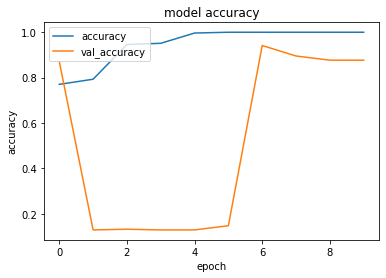

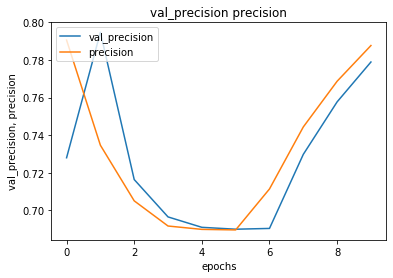

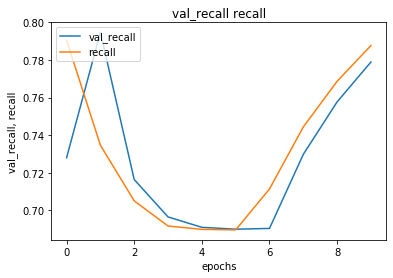

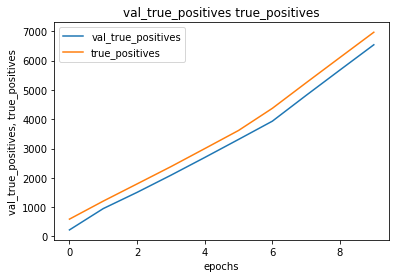

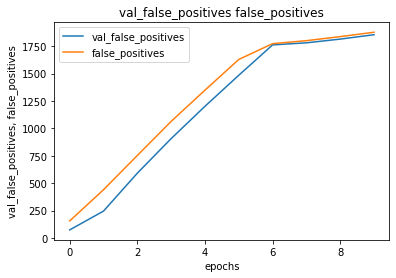

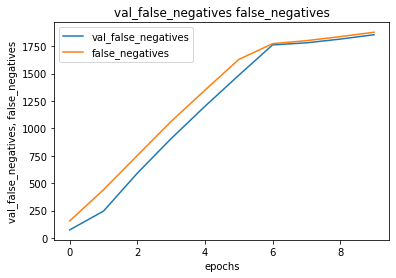

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['loss', 'val_loss'], loc='upper left')
# plt.show()

# plt.plot(history.history['recall'])
# plt.plot(history.history['precision'])
# plt.plot(history.history['val_precision'])
# plt.plot(history.history['val_recall'])
# plt.title('recall precision')
# plt.ylabel('recall, precision')
# plt.xlabel('epochs')
# plt.legend(['recall', 'precision'], loc='upper left')
# plt.show()

plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('val_precision precision')
plt.ylabel('val_precision, precision')
plt.xlabel('epochs')
plt.legend(['val_precision', 'precision'], loc='upper left')
plt.show()


plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('val_recall recall')
plt.ylabel('val_recall, recall')
plt.xlabel('epochs')
plt.legend(['val_recall', 'recall'], loc='upper left')
plt.show()

plt.plot(history.history['true_positives'])
plt.plot(history.history['val_true_positives'])
plt.title('val_true_positives true_positives')
plt.ylabel('val_true_positives, true_positives')
plt.xlabel('epochs')
plt.legend(['val_true_positives', 'true_positives'], loc='upper left')
plt.show()

plt.plot(history.history['false_positives'])
plt.plot(history.history['val_false_positives'])
plt.title('val_false_positives false_positives')
plt.ylabel('val_false_positives, false_positives')
plt.xlabel('epochs')
plt.legend(['val_false_positives', 'false_positives'], loc='upper left')
plt.show()

plt.plot(history.history['false_negatives'])
plt.plot(history.history['val_false_negatives'])
plt.title('val_false_negatives false_negatives')
plt.ylabel('val_false_negatives, false_negatives')
plt.xlabel('epochs')
plt.legend(['val_false_negatives', 'false_negatives'], loc='upper left')
plt.show()

In [24]:
test_positives = 0
test_negatives = 0
pred_positives = 0
pred_negatives = 0
for value in to_categorical(y_test):
#     print(value)
    if value[0] == 0:
        test_positives += 1
    else:
        test_negatives += 1
        
for value in K.round(K.clip(y_pred, 0, 1)):
#     print(value)
    if value[0] == 0:
        pred_positives += 1
    else:
        pred_negatives += 1        

print(test_positives)
print(test_negatives)
print(pred_positives)
print(pred_negatives)

25
225
2
248


In [84]:
y_test.shape

(32768, 1)

## Load model

In [ ]:
custom_objects = {}
custom_objects["precision"] = precision
custom_objects["recall_1"] = tensorflow.keras.metrics.Recall
custom_objects["true_positives_1"] = tensorflow.keras.metrics.TruePositives
custom_objects["false_positives_1"] = tensorflow.keras.metrics.FalsePositives
custom_objects["false_negatives_1"] = tensorflow.keras.metrics.FalseNegatives


loaded_model = tf.keras.models.load_model('eop_' + model_name, custom_objects=custom_objects)